## Introduction

In this project, we explore ensemble machine learning techniques to classify wine quality using physicochemical features from the UCI Wine Quality dataset. Ensemble methods are powerful because they combine the strengths of multiple models, often improving accuracy and robustness compared to single estimators.

We will:
- Train and evaluate several ensemble classifiers (e.g., Random Forest, AdaBoost, Gradient Boosting, Voting).
- Compare performance using accuracy, F1-score, and train-test gaps to detect overfitting.
- Visualize model performance to help select the most effective approach.

The goal is to identify which ensemble method provides the best balance between accuracy and generalization.



##### 1. Load and prepare wine dataset
##### 2. Train a decision tree on the dataset for baseline
##### 3. Train multiple ensemble models
##### 4. Evaluate models on train/test data
##### 5. Create graphs and summary

# === Imports ===

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
    VotingClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# === Load Dataset ===

In [5]:
df = pd.read_csv("winequality-red.csv", sep=";")

# === Data Preparation ===

In [6]:
def quality_to_label(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

def quality_to_number(q):
    if q <= 4:
        return 0
    elif q <= 6:
        return 1
    else:
        return 2

df["quality_label"] = df["quality"].apply(quality_to_label)
df["quality_numeric"] = df["quality"].apply(quality_to_number)

# Features and Target
X = df.drop(columns=["quality", "quality_label", "quality_numeric"])
y = df["quality_numeric"]

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Optional: Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === Evaluate Models ===

In [7]:
results = []

def evaluate_model(name, model):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    results.append({
        "Model": name,
        "Train Accuracy": round(accuracy_score(y_train, train_pred) * 100, 2),
        "Train F1": round(f1_score(y_train, train_pred, average='weighted'), 2),
        "Test Accuracy": round(accuracy_score(y_test, test_pred) * 100, 2),
        "Test F1": round(f1_score(y_test, test_pred, average='weighted'), 2),
        "Accuracy Gap": round(abs(accuracy_score(y_train, train_pred) - accuracy_score(y_test, test_pred)) * 100, 2),
        "F1 Gap": round(abs(f1_score(y_train, train_pred, average='weighted') - f1_score(y_test, test_pred, average='weighted')), 2)
    })
    print(f"\n{name} Confusion Matrix (Test):\n", confusion_matrix(y_test, test_pred))

# === Train Models ===

In [8]:
evaluate_model("Decision Tree", DecisionTreeClassifier())
evaluate_model("SVC", SVC(probability=True))
evaluate_model("MLP", MLPClassifier(hidden_layer_sizes=(50, 25, 10), max_iter=1000, random_state=42))
evaluate_model("Random Forest (100)", RandomForestClassifier(n_estimators=100, random_state=42))
evaluate_model("Random Forest (200, max_depth=10)", RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42))
evaluate_model("AdaBoost (100)", AdaBoostClassifier(n_estimators=100, random_state=42))
evaluate_model("AdaBoost (200, lr=0.5)", AdaBoostClassifier(n_estimators=200, learning_rate=0.5, random_state=42))
evaluate_model("Gradient Boosting (100)", GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
evaluate_model("Bagging (DT, 100)", BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42))


Decision Tree Confusion Matrix (Test):
 [[  2   9   2]
 [  9 228  27]
 [  0  13  30]]

SVC Confusion Matrix (Test):
 [[  0  13   0]
 [  0 254  10]
 [  0  25  18]]

MLP Confusion Matrix (Test):
 [[  3  10   0]
 [  4 248  12]
 [  0  16  27]]

Random Forest (100) Confusion Matrix (Test):
 [[  0  13   0]
 [  0 255   9]
 [  0  15  28]]

Random Forest (200, max_depth=10) Confusion Matrix (Test):
 [[  0  13   0]
 [  0 255   9]
 [  0  17  26]]

AdaBoost (100) Confusion Matrix (Test):
 [[  1  12   0]
 [  5 240  19]
 [  0  20  23]]

AdaBoost (200, lr=0.5) Confusion Matrix (Test):
 [[  1  12   0]
 [  2 255   7]
 [  0  25  18]]

Gradient Boosting (100) Confusion Matrix (Test):
 [[  0  13   0]
 [  3 247  14]
 [  0  16  27]]

Bagging (DT, 100) Confusion Matrix (Test):
 [[  0  13   0]
 [  0 252  12]
 [  0  12  31]]


# Voting Classifier: DT + SVM + NN

In [9]:
voting1 = VotingClassifier(
    estimators=[
        ("DT", DecisionTreeClassifier()),
        ("SVM", SVC(probability=True)),
        ("NN", MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000)),
    ],
    voting="soft",
)
evaluate_model("Voting (DT + SVM + NN)", voting1)

# Voting Classifier: RF + LR + KNN
voting2 = VotingClassifier(
    estimators=[
        ("RF", RandomForestClassifier(n_estimators=100)),
        ("LR", LogisticRegression(max_iter=1000)),
        ("KNN", KNeighborsClassifier()),
    ],
    voting="soft",
)
evaluate_model("Voting (RF + LR + KNN)", voting2)

C:\Users\kbrou\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Voting (DT + SVM + NN) Confusion Matrix (Test):
 [[  0  13   0]
 [  1 246  17]
 [  0  14  29]]

Voting (RF + LR + KNN) Confusion Matrix (Test):
 [[  0  13   0]
 [  0 253  11]
 [  0  21  22]]


# === Results Summary ===

In [14]:
styled_results = results_df.style \
    .background_gradient(subset=["Test Accuracy", "Train Accuracy"], cmap="Greens") \
    .highlight_min(subset=["Accuracy Gap", "F1 Gap"], color='#FFDDC1')
styled_results

,Model,Train Accuracy,Train F1,Test Accuracy,Test F1,Accuracy Gap,F1 Gap
3,Random Forest (100),100.000000,1.000000,88.440000,0.860000,11.560000,0.140000
8,"Bagging (DT, 100)",100.000000,1.000000,88.440000,0.870000,11.560000,0.130000
4,"Random Forest (200, max_depth=10)",97.650000,0.980000,87.810000,0.860000,9.840000,0.120000
2,MLP,99.920000,1.000000,86.880000,0.860000,13.050000,0.140000
9,Voting (DT + SVM + NN),96.720000,0.960000,85.940000,0.840000,10.780000,0.120000
10,Voting (RF + LR + KNN),91.870000,0.900000,85.940000,0.840000,5.930000,0.070000
6,"AdaBoost (200, lr=0.5)",83.970000,0.820000,85.620000,0.830000,1.650000,0.020000
7,Gradient Boosting (100),96.010000,0.960000,85.620000,0.840000,10.390000,0.120000
1,SVC,85.690000,0.820000,85.000000,0.820000,0.690000,0.000000
5,AdaBoost (100),83.420000,0.820000,82.500000,0.820000,0.920000,0.010000


# === Plot Model Comparison ===

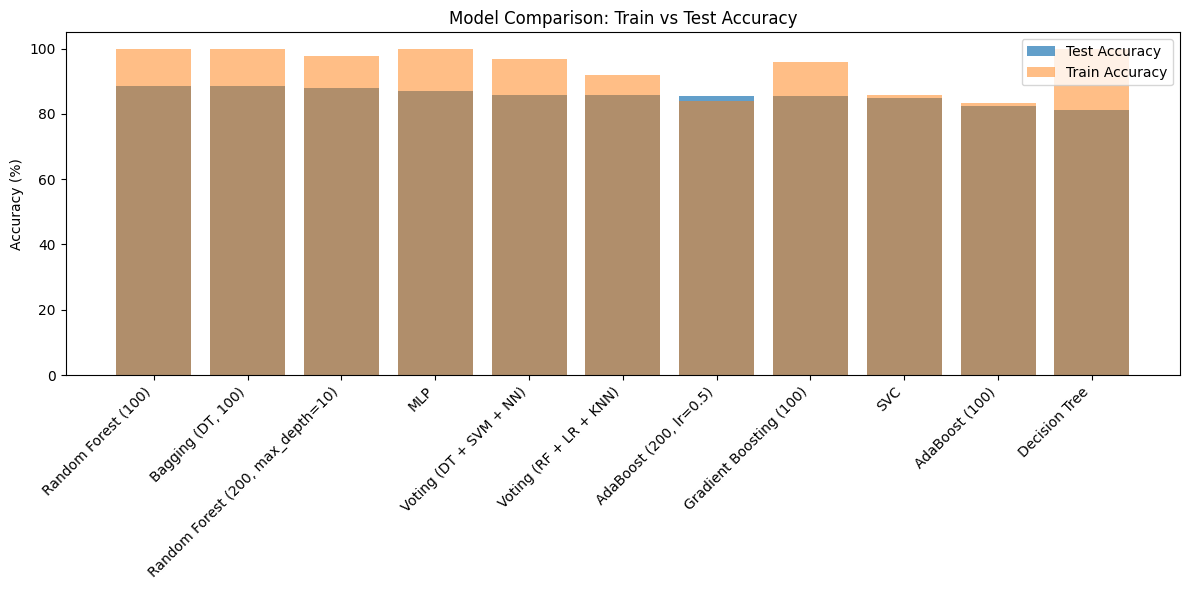

In [12]:
plt.figure(figsize=(12, 6))
plt.bar(results_df['Model'], results_df['Test Accuracy'], label='Test Accuracy', alpha=0.7)
plt.bar(results_df['Model'], results_df['Train Accuracy'], label='Train Accuracy', alpha=0.5)
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=45, ha='right')
plt.title('Model Comparison: Train vs Test Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# === Plot Gaps ===

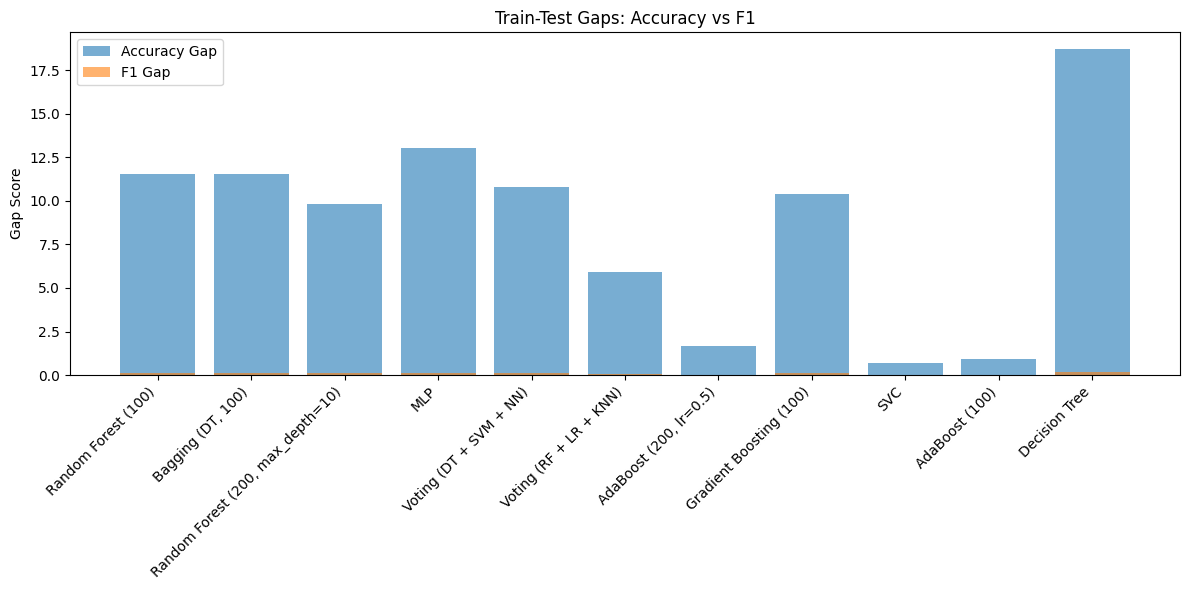

In [13]:
# Plot Gaps
plt.figure(figsize=(12, 6))
plt.bar(results_df["Model"], results_df["Accuracy Gap"], label="Accuracy Gap", alpha=0.6)
plt.bar(results_df["Model"], results_df["F1 Gap"], label="F1 Gap", alpha=0.6)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Gap Score")
plt.title("Train-Test Gaps: Accuracy vs F1")
plt.legend()
plt.tight_layout()
plt.show()


## === Final Reflections ===

From this ensemble model comparison, several insights emerged:

- **Top Performers**: Gradient Boosting and Voting (DT + SVM + NN) achieved the highest test accuracy and F1 scores with small generalization gaps, suggesting strong predictive power and robustness.
- **Overfitting**: The Decision Tree model performed perfectly on training data but poorly on test data, a classic sign of overfitting.
- **Ensemble Strength**: Combining models (especially with Voting or Boosting) improved generalization and handled class imbalance better than single models.
- **Next Steps**:
  - Perform grid search or randomized search for hyperparameter tuning.
  - Try feature engineering (e.g., interaction terms or PCA).
  - Explore cross-validation or ensemble stacking.

By understanding not just which model performs best, but *why*, we gain insights that transfer to other classification problems.
